In [53]:
import networkx as nx
from random import randint
from random import uniform
from random import choice

class GraphGenerator():
    """GraphGenerator can be used to generate random graph with parameters in input.\n
    The way it does so ensures that there are no isolates nodes (there should be at least 2 nodes in the generated graph)"""
    def generate_random_ER_graph(self, nmin=2, nmax=10, pmin=0.2, pmax=1):
        """Erdős-Rényi graph generation.\n
        Parameters:
        1. nmin, min number of nodes: >= 2
        2. nmax, max number of nodes: >= nmin
        3. pmin, min probability for edge creation: >= 0.01
        4. pmax, max probability for edge creation: <= 1
        """
        n  = randint(nmin, nmax) # Number of nodes
        p = uniform(pmin, pmax) # Probability for edge creation
        G = nx.gnp_random_graph(n, p, seed=None, directed=False)
        return self._make_connected(G)

    def generate_random_BA_graph(self, nmin=2, nmax=10):
        """Erdős-Rényi graph generation.\n
        Parameters:
        1. nmin, min number of nodes: nmin >= 2
        2. nmax, max number of nodes: >= nmin
        """
        n  = randint(nmin, nmax) # Number of nodes
        m = randint(1, n-1) # Number of edges to attach from a new node to existing nodes,
        if not (m >= 1 and m < n):
            raise Exception(f"m >= 1 and m < n", f"m={m}", f"n={n}")
        G = nx.barabasi_albert_graph(n, m, seed=None, initial_graph=None)
        return self._make_connected(G)
    
    def _make_connected(self, G : nx.Graph):
        for node in list(nx.isolates(G)):
            target_node = choice([n for n in G.nodes() if n != node])
            G.add_edge(node, target_node)
        return G

In [54]:
from abc import ABC, abstractmethod
import networkx as nx
from typing import List
from random import randint
from random import random
from copy import deepcopy

class UnprocessableError(Exception):
    """Error raised when no further process can be applied (useful in some Consecutor)"""
    pass

class Consecutor(ABC):
    """Abstract Consecutor with base utility methods ready for the concrete Consecutor.
    \nUsed to generate a Graph G' from G."""
    def next(self, G : nx.Graph) -> tuple[nx.Graph, int]:
        """Return a tuple with a new graph G' and the distance from G (can be 0)"""
        if not self._is_processable(G):
            raise UnprocessableError()
        copy = deepcopy(G)
        rand = random()
        return self._next(copy, rand)
    
    @abstractmethod
    def _next(self, G : nx.Graph, rand : float) -> tuple[nx.Graph, int]:
        """Actual next logic from concrete classes"""
        raise NotImplementedError()
    
    def _is_processable(self, G : nx.Graph) -> bool:
        """Whether you can make a 'next' on graph G"""
        return len(self._nodes(G)) > 0
    
    def _nodes(self, G : nx.Graph) -> List[int]:
        """Return the list of nodes of the graph G"""
        return list(G.nodes)
    
    def _edges(self, G : nx.Graph) -> List[tuple[int, int]]:
        """Return the list of edges of the graph G"""
        return list(G.edges)
    
    def _rand_obj_list(self, l : List) -> object | None:
        """Return a random object in list if not empty else None"""
        return l[randint(0, len(l) - 1)] if len(l) > 0 else None
    
    def _new_node(self, G : nx.Graph) -> int:
        """Return a new node for the graph G (biggest indexed node + 1)"""
        return (self._nodes(G)[-1] + 1) if len(self._nodes(G)) > 0 else 0
    
    def _rand_node(self, G : nx.Graph) -> int | None:
        """Return a random existing node of G if any else None"""
        return self._rand_obj_list(self._nodes(G))
    
    def _new_edge(self, G : nx.Graph) -> tuple[int, int] | None:
        """Return a new edgre for the graph G if not fully-connected else None"""
        return self._rand_obj_list(list(nx.non_edges(G)))
    
    def _rand_edge(self, G : nx.Graph) -> tuple[int, int] | None:
        """Return a random existing edge of G if any else None"""
        return self._rand_obj_list(self._edges(G))

In [55]:
class IncrementalConsecutor(Consecutor):
    """IncrementalConsecutor add nodes and edges. The way it does so ensures there are no isolates at any moment."""
    def _next(self, G : nx.Graph, rand : float) -> tuple[nx.Graph, int]:
        if rand <= 0.33:
            return self.__add_node_and_edges(G)
        else:
            return self.__add_edge(G)
    
    def __add_node_and_edges(self, G : nx.Graph) -> tuple[nx.Graph, int]:
        """Add a new node and k edges from the new node to random nodes"""
        new_node = super()._new_node(G)
        G.add_node(new_node)
        nodes = super()._nodes(G)
        k = randint(1, len(nodes) - 1)
        choices = list(filter(lambda n : n != new_node, nodes))
        for _ in range(0, k):
            target = super()._rand_obj_list(choices)
            G.add_edge(new_node, target)
            choices.remove(target)
        return G, (1+k)
            
    def __add_edge(self, G : nx.Graph) -> tuple[nx.Graph, int]:
        """Add a new edge if not fully connected"""
        new_edge = super()._new_edge(G)
        if new_edge is None:
            return G, 0
        G.add_edge(*new_edge)
        return G, 1
        

In [56]:
class DecrementalConsecutor(Consecutor):
    """DecrementalConsecutor removes nodes and edges, after any atomic operation it also removes isolated nodes.
    \nThis is due to how data is stored (edge adj matrix which drops isolates informations)."""
    def _next(self, G : nx.Graph, rand : float) -> tuple[nx.Graph, int]:
        if rand <= 0.33:
            return self._remove_edge(G)
        else:
            return self._remove_node_and_edges(G)
        
    def _remove_node_and_edges(self, G : nx.Graph) -> tuple[nx.Graph, int]:
        """Remove a random node along with its edges, if this causes a node to be isolated it is removed aswell"""
        rvm_node = self._rand_node(G)
        if rvm_node is None:
            return G, 0
        degree = G.degree(rvm_node)
        G.remove_node(rvm_node)
        isolated = list(nx.isolates(G))
        G.remove_nodes_from(isolated)
        return G, (1+degree+len(isolated))
            
    def _remove_edge(self, G : nx.Graph) -> tuple[nx.Graph, int]:
        """Remove a random edge if there are any, if this causes a node to be isolated it is removed aswell"""
        rvm_edge = self._rand_edge(G)
        if rvm_edge is None:
            return G, 0
        G.remove_edge(*rvm_edge)
        isolated = list(nx.isolates(G))
        G.remove_nodes_from(isolated)
        return G, (1+len(isolated))
        

In [57]:
from typing import Dict, Callable
from itertools import combinations

class ConsecutorExecutor():
    """ConsecutorExecutor can be used to execute steps consecutions starting from a graph G"""
    def __init__(self, consecutor: Consecutor):
        self.consecutor = consecutor
    
    def execute(self, 
                G : nx.Graph, 
                steps = 100, 
                stopper : Callable[[nx.Graph], bool] = None,
                skip_zero_ged = True,
                ) -> Dict[int, tuple[nx.Graph, int]]:
        """Perform steps attempts to modify graph G.
        Parameters:
        1. G, the graph where to start from
        2. steps, the number of atomic modifications
        3. stopper, an early custom stopping function
        4. skip_zero_ged, a Consecutor may return a G' with ged 0 w.r.t. G
        Returns a dict representing the history of graph generations with edit distance from previous graph.
        """
        history = {}
        history[-1] = (G, 0)
        for i in range(0, steps):
            try:
                G, ged = self.consecutor.next(G)  # Generation and update G
            except UnprocessableError:
                break
            if ged != 0 or not skip_zero_ged: # Save only when necessary
                history[i] = (G, ged)
            if stopper is not None and stopper(G): # Check if stopping condition applies
                break
        return history

In [58]:
class HistoryChecker():
    """HistoryChecker can be used to assert real red value on history and it also provide a method to calculate history's artificial ged"""
    def __init__(self, history : Dict[int, tuple[nx.Graph, int]]):
        self.history = history
                
    def assert_geds(self):
        """Checks for every entry combination of history real ged distance"""
        all_entries = self.history.items()
        all_combinations = list(combinations(all_entries, 2))
        for comb in all_combinations:
            g1 = comb[0][1][0]
            g2 = comb[1][1][0]
            r = nx.graph_edit_distance(g1, g2)
            e = self.calculate_ged_comb(comb)
            assert r == e
            
    def calculate_ged_comb(self, comb : tuple[tuple[int, tuple[nx.Graph, int]], tuple[int, tuple[nx.Graph, int]]]):
        """Returns the artificial ged distance given an entry combination"""
        delimiters = [comb[0][0], comb[1][0]]
        delimiters.sort()
        return self._sum_ged_k2k(delimiters[0], delimiters[1])
        
    def _sum_ged_k2k(self, min, max):
        """Internal method used to calculate the artificial ged in linear time"""
        entries = self.history.items()
        sum = 0
        for entry in entries:
            key = entry[0]
            value = entry[1]
            if min < key <= max:
                sum += value[1]
            if key > max:
                break
        return sum

In [59]:
import matplotlib.pyplot as plt

def plot_graphs_sbs(g1 : nx.Graph, g2 : nx.Graph):
    """Utility function to plot two graphs side by side"""
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    nx.draw(g1, with_labels=True, font_weight='bold', ax=axes[0])
    nx.draw(g2, with_labels=True, font_weight='bold', ax=axes[1])
    plt.tight_layout()
    plt.show()

def plot_cons_hist_entries(history: Dict[int, tuple[nx.Graph, int]], stop=None):
    """Utility function to plot entries of history in a consecutive manner"""
    entries = list(history.items())
    for i,e in enumerate(entries):
        n = entries[i+1]
        plot_graphs_sbs(e[1][0], n[1][0])
        if stop is not None and i+1 == stop:
            break
        if i+1 == len(entries) - 1:
            break 

In [60]:
import pandas as pd
from itertools import combinations
from json import dump

class HistorySaver():
    """HistorySaver is responsible for storing to disk the history in a proper manner.\n
    Combination_filter parameter is a function used to filter out entries that are not wanted.
    """
    def __init__(self, history : Dict[int, tuple[nx.Graph, int]], combination_filter : Callable[[tuple[int, tuple[nx.Graph, int]]], bool]):
        self.historyChecker = HistoryChecker(history)
        self.history = history
        self._df = self._build_df(combination_filter)
        
    def _build_df(self, combination_filter : Callable[[tuple[int, tuple[nx.Graph, int]]], bool]):
        """Function that generate a private dataframe which will be exploited for IO operations"""
        entries = list(self.history.items())
        all_combs = list(combinations(entries, 2))
        filtered_combs = list(filter(combination_filter, all_combs))
        df = pd.DataFrame({
            "graph_1": list(map(lambda c : list(c[0][1][0].edges), filtered_combs)),
            "graph_2": list(map(lambda c : list(c[1][1][0].edges), filtered_combs)),
            "ged": list(map(lambda c : self.historyChecker.calculate_ged_comb(c), filtered_combs)),
        })
        return df
        
    def save_dense_json(self, path : str):
        self._df.to_json(path, force_ascii=False, default_handler=vars, orient='records', lines=True)
        

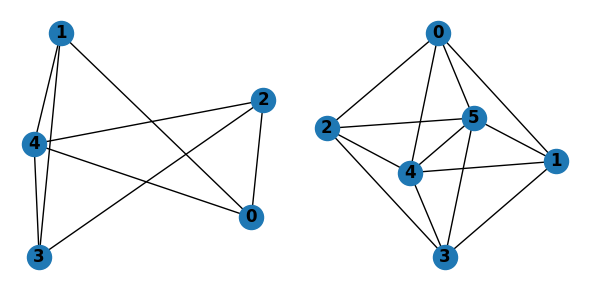

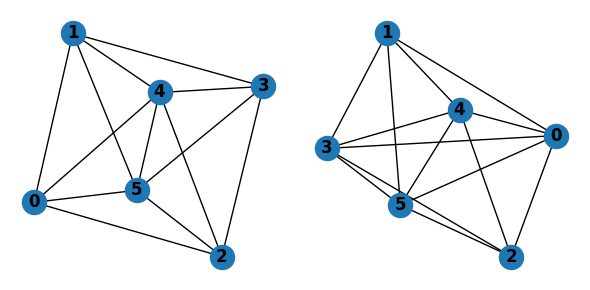

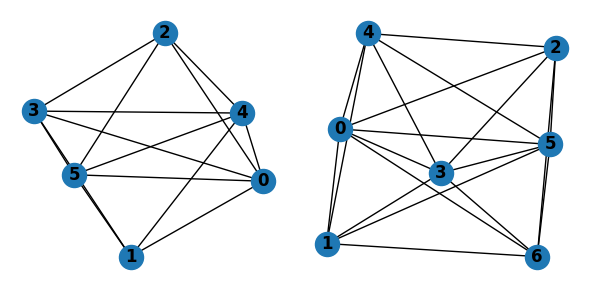

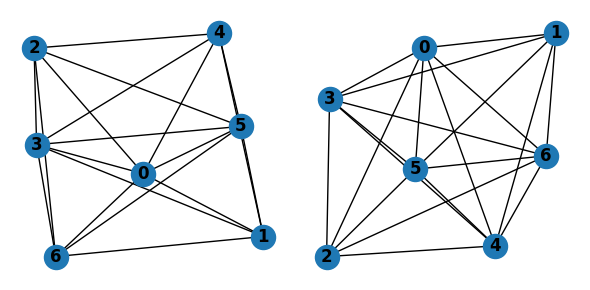

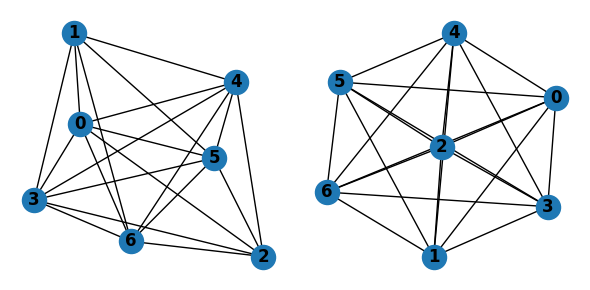

In [61]:
generator = GraphGenerator()
start = generator.generate_random_ER_graph()

inc_consecutor = IncrementalConsecutor()
exc_consecutor = ConsecutorExecutor(inc_consecutor)

history = exc_consecutor.execute(start, steps=10)
HistoryChecker(history).assert_geds()

plot_cons_hist_entries(history, stop=5)

saver = HistorySaver(history, lambda c : True)
saver.save_dense_json('./dataset/incremental.json')

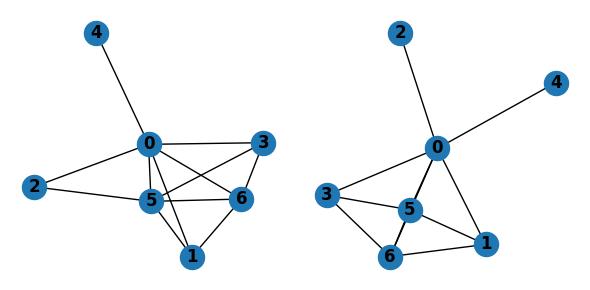

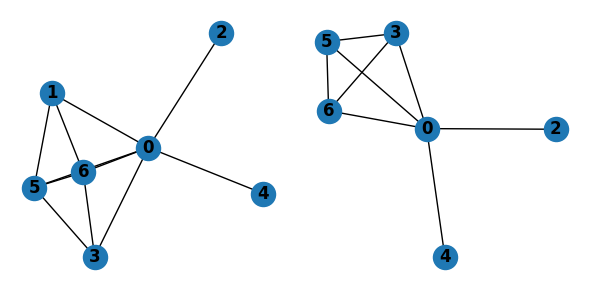

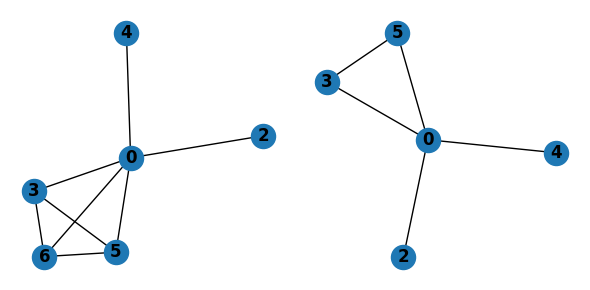

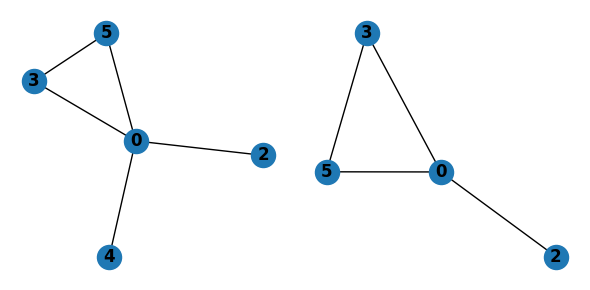

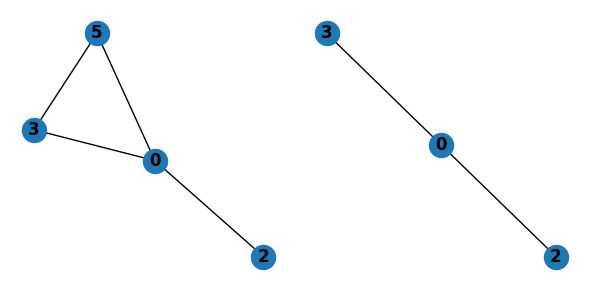

In [62]:
generator = GraphGenerator()
start = generator.generate_random_BA_graph()

dec_consecutor = DecrementalConsecutor()
exc_consecutor = ConsecutorExecutor(dec_consecutor)

history = exc_consecutor.execute(start, steps=20)
HistoryChecker(history).assert_geds()

plot_cons_hist_entries(history, stop=5)

saver = HistorySaver(history, lambda c : True)
saver.save_dense_json('./dataset/decremental.json')

In [63]:
import pandas as pd

df = pd.read_json('./dataset/decremental.json', orient='records', lines=True)
g1s = df.graph_1.to_list()
g2s = df.graph_2.to_list()
geds = df.ged.to_list()

for i in range(len(g1s)):
    G1 = nx.Graph(g1s[i])
    G2 = nx.Graph(g2s[i])
    ged = geds[i]
    rged = nx.graph_edit_distance(G1, G2)
    assert rged == ged